In [1]:
# %%time
## Just an easy way to load utility functions
dataset_name = "W19_only"
df_list = []

%matplotlib inline 
%run f2f_header.py {dataset_name} {df_list}

global BES_label_list, BES_df_list

# %run f2f_utility.py

BES_df_list = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\BES_df_list.pickle", "rb" ) )
# f2f_harmonised = pd.read_pickle("E:\\BES_analysis_data\\Face_to_face\\f2f_harmonised.zip", compression='zip')
BES_label_list = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\BES_label_list.pickle", "rb" ) )
demo_var_dict = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\demo_var_dict.pickle", "rb" ) )
var_type_dict_nonans = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\var_type_dict_nonans.pickle", "rb" ) )

f2f_harmonised = pd.read_pickle("E:\\BES_analysis_data\\Face_to_face\\f2f_harmonised_temp.zip", compression='zip')


generic_cols = f2f_harmonised.columns
list_of_scale_harm_vars = ["Age","year_past_min_sch_leave_age","in_school_past_min_age"]



## BUGS

BES_label_list["1959"]["v1236"] = 'LOCAL ELECTION VOTE 1963(2nd)'
BES_label_list["1964"]["v1236"] = 'LOCAL ELECTION VOTE 1963(2nd)'
BES_label_list["1966"]["v1236"] = 'LOCAL ELECTION VOTE 1963(2nd)'
BES_label_list["1970"]["v1236"] = 'LOCAL ELECTION VOTE 1963(2nd)'

BES_label_list["2015"]['edlevel'] = 'Education level (summary)'

Toggle code

2023-05-29 20:24:20,025 WARNING: panel.io.resources - Mimetype declaration for .js files was set to 'text/plain'. This will interefere with serving JS modules. Ensure your system does not override the mimetype declaration and/or contact your system administrator. 


In [2]:
weights = pd.read_pickle("E:\\BES_analysis_data\\Face_to_face\\weights.zip", compression='zip')
f2f_harmonised["wt"] = weights["wt_vote"]
values = pd.read_pickle("E:\\BES_analysis_data\\Face_to_face\\f2f_harmonised_values.zip", compression='zip')
f2f_harmonised[values.columns]=values

,inc_det,inc_norm,inc_norm_wt
inc_det,1.000000,0.928029,0.860604
inc_norm,0.928029,1.000000,0.945883
inc_norm_wt,0.860604,0.945883,1.000000


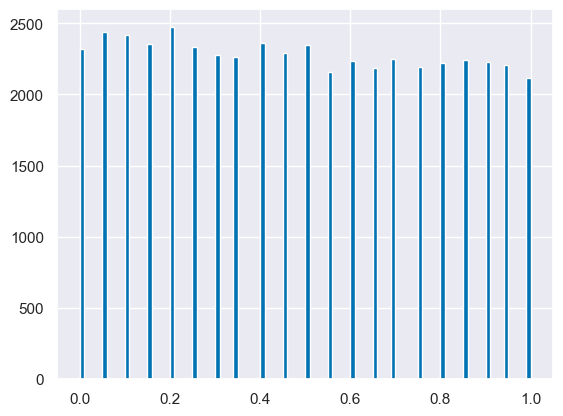

In [3]:
wt_means = f2f_harmonised.groupby("dataset")["wt"].mean().to_dict()
f2f_harmonised["wt_norm"] = f2f_harmonised.apply(lambda x: x["wt"]/wt_means[x["dataset"]] , axis=1 )

f2f_harmonised["AuthRight"] = f2f_harmonised["bloc_complete"]=="Right-Auth"
f2f_harmonised["LibLeft"] = f2f_harmonised["bloc_complete"]=="Left-Lib"

f2f_harmonised["CON"] = f2f_harmonised["vote_complete_simple"]=="CON"
f2f_harmonised["LAB"] = f2f_harmonised["vote_complete_simple"]=="LAB"
f2f_harmonised["DNV"] = f2f_harmonised["vote_complete_simple"]=="DNV"
f2f_harmonised["LD"]  = f2f_harmonised["vote_complete_simple"]=="LD"
f2f_harmonised["REFUK"]  = f2f_harmonised["vote_complete_simple"]=="REFUK"
f2f_harmonised["SNP"]  = f2f_harmonised["vote_complete_simple"]=="SNP"
f2f_harmonised["GP"]  = f2f_harmonised["vote_complete_simple"]=="GP"
f2f_harmonised["DK"]  = f2f_harmonised["vote_complete_simple"]=="DK"
f2f_harmonised["PC"]  = f2f_harmonised["vote_complete_simple"]=="PC"
f2f_harmonised["decade"] = f2f_harmonised["age"]/10
f2f_harmonised["generation"] = f2f_harmonised["age"]/20
inc_maxes = f2f_harmonised.groupby("dataset")["inc_det"].max().to_dict()
f2f_harmonised["inc_norm"] = f2f_harmonised.apply(lambda x: x["inc_det"]/inc_maxes[x["dataset"]] , axis=1 )#.groupby(f2f_harmonised["dataset"]).hist()
## do a proper version with weighting/quantiles

f2f_harmonised["inc_norm_wt"]=np.nan
temp = (f2f_harmonised[f2f_harmonised["wt"].notnull()].groupby("dataset").apply(lambda x: weighted_qcut(x["inc_det"],x["wt"],21)).cat.codes/20)
reverse_dict = {v:k for k,v in f2f_harmonised[f2f_harmonised["wt"].notnull()].groupby("dataset").apply(lambda x: x["uid"]).to_dict().items()}
f2f_harmonised.loc[f2f_harmonised["wt"].notnull(),"inc_norm_wt"]=temp.loc[f2f_harmonised["uid"][f2f_harmonised["wt"].notnull()].apply(lambda x: reverse_dict[x])].values
# weighted_qcut

f2f_harmonised["inc(quartile)"] = f2f_harmonised["inc_norm_wt"]*4
f2f_harmonised["inc_norm_wt"].hist(bins=100)
f2f_harmonised[["inc_det","inc_norm","inc_norm_wt"]].corr()

In [4]:
ge_to_date_dict = {'1959':"8/10/1959", '1964':"15/10/1964", '1966':"31/3/1966", '1970':"18/6/1970", '1974_feb':"28/2/1974",
 '1974_oct':"10/10/1974", '1979':"5/3/1979", '1983':"9/6/1983",'1987':"11/6/1987", '1992':"9/4/1992",
 '1997':"1/5/1997", '2001':"7/6/2001", '2005':"5/5/2005", '2010':"6/5/2010", '2015':"7/5/2015",
 '2017':"8/6/2017", '2019':"12/12/2019"}

def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
#     raise Exception
    data.plot(x=x, y=y, yerr=yerr,xerr=None, kind="line", ax=ax, **kwargs)

def OLS_party_housing(variance_scaled = False, regularised=False, regression_type="OLS",const=True,
                     cols = ['age', 'inc_det', 'gender_complete', 'housing'],drop_first=True,dummy_na=False,
                     dummied_cols = None,
                     mask = f2f_harmonised["bloc_complete"].isin(["Left-Lib","Right-Auth"]),
                     target = "auth_right_vote",
                     error_bars=False, hide_const=False,add_actual=False,
                     ax=None,single_legend=False,eyeline=True,alpha_const_actual=True,
                     ge_range = f2f_harmonised["dataset"].unique()):

    import statsmodels.api as sm
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
    wt_var = "wt_norm"
    
    
#     mask = 
    if regression_type=="Weighted_OLS":
        mask = mask & f2f_harmonised[wt_var].notnull()
    if dummied_cols == None:
        dummied_cols = list(pd.get_dummies(f2f_harmonised[cols][mask],drop_first=drop_first,dummy_na=dummy_na).columns)

    if const:
        dummied_cols = ["const"]+dummied_cols
    if add_actual:
        dummied_cols = ["actual"]+dummied_cols
    results_df = pd.DataFrame(columns = dummied_cols)        
    # add error_bar columns
    if error_bars:
        dummied_errs = [x+'_err' for x in dummied_cols]
        results_df[dummied_errs]=np.nan
        
    scaler = StandardScaler()

    for ge in ge_range:
    # ge = "1979"
        df = f2f_harmonised[mask][f2f_harmonised["dataset"][mask]==ge][cols+[target]]
        if regression_type == "Weighted_OLS":
            sample_weight = f2f_harmonised[mask][f2f_harmonised["dataset"][mask]==ge][wt_var]
#             raise Exception
        X = pd.get_dummies(df.drop([target],axis=1),drop_first=drop_first,dummy_na=dummy_na)
        X = X[intersection(X.columns, dummied_cols)]
        
        if variance_scaled:
            X = pd.DataFrame(scaler.fit_transform(X,sample_weight=sample_weight),columns=X.columns,index=X.index)
        if const:
            X = sm.add_constant(X)

        Y = df[target]
        if regression_type == "OLS":
            model = sm.OLS(Y,X)
        elif regression_type == "Logit":
            model = sm.Logit(Y,X)
        elif regression_type == "Probit":
            model = sm.Probit(Y,X)
        elif regression_type == "Weighted_OLS":
            if regularised:
                model = ElasticNet(fit_intercept=False,alpha=0.0)
#                 LinearRegression()
            else:
                model = LinearRegression(fit_intercept=False)
                
            model.fit(X, Y, sample_weight=sample_weight)
            

        # results.params
        if regression_type == "Weighted_OLS":
            results_df.loc[ge,X.columns] = model.coef_
        else:
            if regularised:        
                results = model.fit_regularized()
            else:
                results = model.fit()            
            results_df.loc[ge,X.columns] = results.params.values
            
        # error bars
        # dodgy, grabbing only
        if error_bars:
            if regression_type == "Weighted_OLS":
                model = sm.OLS(Y,X)
            # otherwise use sm model used prior
            results = model.fit()
            errors = results.conf_int()
            results_df.loc[ge,[x+"_err" for x in X.columns]] = (results_df.loc[ge,X.columns]-errors[0]).values
#             raise Exception
        
        if add_actual:
            if regression_type == "Weighted_OLS":
                results_df.loc[ge,"actual"] = sum(Y.loc[X.dropna().index]*sample_weight.loc[X.dropna().index])/sum(sample_weight.loc[X.dropna().index])
#                 (Y.loc[X.dropna().index]*sample_weight.loc[X.dropna().index]).mean()
#                 results_df.loc[ge,"actual"] = Y.mean()
#                 raise Exception
            else:
                results_df.loc[ge,"actual"] = Y.loc[X.dropna().index].mean()

    results_df = results_df.sort_index()

#     else:
#         title = title+"_unscaled"        
#     results_df.plot(kind='line',title=title)  

    if ax is None:
        plt.figure(figsize=(12,6));
        ax=plt.gca()
        
#     if single_legend:
#         legend=False
#     else:
#         legend='auto'
    x_label = "UK GE Date"
    y_label = "Impact on Probability"
    hue_label = "Factor"
    title = 'Probability of Voting: '+target
#     if variance_scaled:
#         title = title+"_scaled"
# #     else:
# #         title = title+"_unscaled"
#     if regularised:
#         title = title+"_regularised"    
    hue_name_replace_dict = {"inc_norm_wt":"income(decile)",
                         "generation":"age(generation)",
                         "gender_complete":"gender(female)",
                         "housing_OWN":"tenure(OWN&MORT)","housing_RENT":"tenure(RENT)",
                         "housing_det_OWN":"tenure(OWN)","housing_det_MORT":"tenure(MORT)","housing_det_OWN-MORT":"tenure(OWN&MORT)",
                         "housing_det_RENT-LA":"tenure(RENT-LA)","housing_det_RENT-PR":"tenure(RENT-PR)","housing_det_RENT-HA":"tenure(RENT-HA)","housing_det_RENT-ALL":"tenure(RENT)",
                         "age_left_education_3_15 or younger":"left_edu(15-)","age_left_education_3_16":"left_edu(16)",
                         "age_left_education_3_18":"left_edu(17-18)","age_left_education_3_19 or older":"left_edu(19+)",
                        }
#     sns.set(font_scale = 2)
    if error_bars:
        res_df = results_df[dummied_cols].reset_index().melt(id_vars='index')
        res_df["index"] = res_df["index"].replace(ge_to_date_dict).apply(lambda x: pd.to_datetime(x))
        res_df.columns = [x_label,hue_label,y_label]
        res_df[y_label] = res_df[y_label.astype('float')]

        err_df = results_df[dummied_errs].reset_index().melt(id_vars='index')
        err_df["index"] = err_df["index"].replace(ge_to_date_dict).apply(lambda x: pd.to_datetime(x))
        err_df.columns = [x_label,hue_label,y_label]
        err_df[y_label] = err_df[y_label].astype('float')
        res_df["yerr"] = err_df[y_label]
        if hide_const:
            res_df = res_df.replace("const",np.nan).dropna()
#         res_df
        res_df=res_df.replace(hue_name_replace_dict)
        g = sns.FacetGrid(res_df, hue=hue_label,height=6,aspect=1.5)
        g.map_dataframe(errplot, x_label, y_label, "yerr",ax=ax)# test ax!
        g.add_legend()    
    
    else:
        

        res_df = results_df.reset_index().melt(id_vars='index')
        res_df["index"] = res_df["index"].replace(ge_to_date_dict).apply(lambda x: pd.to_datetime(x))
        res_df.columns = [x_label,hue_label,y_label]
        res_df[y_label] = res_df[y_label].astype('float')
        if hide_const:
            res_df = res_df.replace("const",np.nan).dropna()
        res_df=res_df.replace(hue_name_replace_dict)
        sns.lineplot(data = res_df,x=x_label,y=y_label,hue=hue_label,style=hue_label,markers=True,ax=ax);
        ax.set_xlabel(x_label,fontsize=16);
        ax.set_ylabel(y_label,fontsize=22);
        ax.set_title(title,fontsize=22);
#         plt.xticks(rotation=90);   
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if eyeline:
        ax.axhline(0, color ='grey', lw = 2, alpha=.2);
    if alpha_const_actual:
        if const or add_actual:
            ax.get_lines()[0].set_alpha(.5);   
        if const and add_actual:
            ax.get_lines()[1].set_alpha(.5);   

    if single_legend:
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
        legend_data = (handles, labels)
    else:
        legend_data = None
    
    
    return res_df,legend_data

def plot_OLS_set(target_list, X_list, figsize=(16.5, 6),  sharey=True, regression_type="Weighted_OLS",regularised=False,
                 variance_scaled=False,drop_first=False,hide_const=False,add_actual=True,dummied_cols=None, single_legend=True,
                 mask=f2f_harmonised["vote_complete_simple"].notnull()&f2f_harmonised["wt"].notnull(),
                 ge_range = f2f_harmonised["dataset"].unique()):
    
    fig, axs = plt.subplots(ncols=len(target_list),figsize=figsize, sharey=sharey);
    ax_pos = 0
    for target in target_list:
        df,(handles, labels)=OLS_party_housing(variance_scaled=variance_scaled,drop_first=drop_first,cols = X_list,
                    target=target,mask = mask,
                    regression_type=regression_type, regularised=regularised, hide_const=hide_const,add_actual=add_actual,
                    dummied_cols=dummied_cols,single_legend=single_legend,
                    ax=axs[ax_pos],ge_range=ge_range)
        ax_pos=ax_pos+1
    if single_legend:
#         handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, 
                   loc='upper center',
                   bbox_to_anchor=(0.5, 0.05), bbox_transform = plt.gcf().transFigure,
                   fancybox=False, shadow=False, ncol=5);
#         raise Exception
#     return (handles, labels)

In [5]:
{x:{k:v for k,v in BES_label_list[x].items() if re.search("residence type|description of accommodation|floor level of main accommodation|type of house|dwelling type",v.lower()) } for x in BES_label_list.keys()}

{'2019': {},
 '2017': {},
 '2015': {'dwel_type': 'Select dwelling type'},
 '2010': {},
 '2005': {'sadtype': 'description of accommodation'},
 '2001': {},
 '1997': {'homenr': 'record sampled dwelling type  q141',
  'levelnr': 'floor level of main accommodation?  q145'},
 '1992': {},
 '1987': {},
 '1983': {},
 '1979': {'m215285': 'type of house r lives in-q110a'},
 '1974_feb': {'feb215': 'residence type'},
 '1974_oct': {'oct215': 'residence type'},
 '1970': {},
 '1966': {},
 '1964': {},
 '1959': {}}

In [6]:
{k:v for k,v in BES_label_list.keys()}

ValueError: too many values to unpack (expected 2)

In [ ]:
BES_label_list["1979"]["m215285"],BES_label_list["1974_feb"]["feb215"],BES_label_list["1974_oct"]["oct215"],\
    BES_label_list["2015"]["dwel_type"],BES_label_list["2019"]["dwelling_type"],BES_label_list["1997"]["homenr"],\
    BES_label_list["1997"]["flatnr"],BES_label_list["1987"]["v60ab"],BES_label_list["1983"]["q65ab"],

In [ ]:
# semi-detached/semi, detached, terraced, flat, bedsit, flat,maisonette,bsit
    # 0, institution, other, caravan, tenement
    
# flat/maisonette vs house




In [21]:
replace_dict = {
                "semi":"semi-detached house","whole hse semi-detached":"semi-detached house",2.0:"semi-detached house",
                    "Semi-detached / end terraced house":"semi-detached house","Semi-detached / end terrace house":"semi-detached house",
                    "semi-detached":"semi-detached house",
                "terraced":"terraced house","whole hse mid-terrace":"terraced house",3.0:"terraced house",
                    "Centre terraced house":"terraced house",
                
                "whole hse semi-detached":"semi-detached excl end-terrace",
                "whole hse end terrace":"end-terrace house",
    
                "detached":"detached house","whole hse detached":"detached house",1.0:"detached house",
                    "Detached house":"detached house",
                "Bungalow":"bungalow",
                "flat":"flat",
                    "flat/maisonette purpose-built":"purpose-built flat",4.0:"purpose-built flat","Purpose built flat":"purpose-built flat",
                        "Purpose built flat / maisonette":"purpose-built flat",
                    "converted flat/maisonette":"converted flat",5.0:"converted flat","Conversion flat / maisonette":"converted flat",
                        "Conversion flat / maisonnette":"converted flat",
                "bedsit":"bedsit","rooms, bedsitter":"bedsit",
                "institution":"institution",
                "other":"other",6.0:"other","Other type of dwelling":"other","Other":"other",
                "caravan":"caravan",
                0:"DK","don't   know":"DK",9.0:"DK","Unable to obtain information":"DK","don't   know":"DK",
                "tenement":"tenement",
                "flat,maisonette,bsit":"flat,maisonette,bsit",
    
               }

In [22]:
f2f_harmonised["residence_type"] = np.nan
mask = f2f_harmonised["dataset"]=="1974_feb"
f2f_harmonised.loc[mask,"residence_type"] = BES_df_list["1974_feb"]["feb215"].replace(replace_dict)

mask = f2f_harmonised["dataset"]=="1974_oct"
f2f_harmonised.loc[mask,"residence_type"] = BES_df_list["1974_oct"]["oct215"].replace(replace_dict)

mask = f2f_harmonised["dataset"]=="1979"
f2f_harmonised.loc[mask,"residence_type"] = BES_df_list["1979"]["m215285"].replace(replace_dict)

mask = f2f_harmonised["dataset"]=="1997"
f2f_harmonised.loc[mask,"residence_type"] = BES_df_list["1997"]["homenr"].replace(replace_dict)

mask = f2f_harmonised["dataset"]=="2005"
f2f_harmonised.loc[mask,"residence_type"] = BES_df_list["2005"]["sadtype"].replace(replace_dict)

mask = f2f_harmonised["dataset"]=="2015"
f2f_harmonised.loc[mask,"residence_type"] = BES_df_list["2015"]["dwel_type"].replace(replace_dict)

mask = f2f_harmonised["dataset"]=="2019"
f2f_harmonised.loc[mask,"residence_type"] = BES_df_list["2019"]["dwelling_type"].replace(replace_dict)

# mask = f2f_harmonised["dataset"]=="1974_feb"
# f2f_harmonised.loc[mask,"residence_type"] = BES_df_list["1974_feb"]["feb215"].replace(replace_dict)

# mask = f2f_harmonised["dataset"]=="1974_feb"
# f2f_harmonised.loc[mask,"residence_type"] = BES_df_list["1974_feb"]["feb215"].replace(replace_dict)


In [26]:
f2f_harmonised["residence_type"] = f2f_harmonised["residence_type"].astype('category')
f2f_harmonised["residence_type"].value_counts()

semi-detached house               5874
detached house                    4181
terraced house                    4107
purpose-built flat                1797
semi-detached excl end-terrace    1157
flat                               714
converted flat                     315
bungalow                           306
end-terrace house                  303
flat,maisonette,bsit               257
other                              139
bedsit                             107
institution                         49
DK                                  43
caravan                             16
tenement                             4
Name: residence_type, dtype: int64

In [10]:
BES_df_list["1974_feb"]["feb215"].replace(replace_dict).value_counts(dropna=False)

semi-detached house    990
terraced house         572
detached house         499
flat                   331
bedsit                  23
DK                      17
institution             13
other                   11
caravan                  6
Name: feb215, dtype: int64

In [38]:
BES_df_list["1974_oct"]["oct215"].replace(replace_dict).value_counts()

semi-detached house    954
detached house         478
terraced house         411
flat                   383
bedsit                  77
other                   17
institution             14
caravan                  5
Name: oct215, dtype: int64

In [42]:
BES_df_list["1979"]["m215285"].replace(replace_dict).value_counts()

semi-detached           703
terraced house          492
detached house          366
flat,maisonette,bsit    257
other                    23
institution              22
DK                       21
caravan                   5
tenement                  4
Name: m215285, dtype: int64

In [40]:
replace_dict = {
    "owns    house":"house",
    "owns house":"house",
    "loc auth--house":"house",
    "rent--private":np.nan,
    "rent hse la":"house",
    "rent flt la":"flat",
    "loc auth--flat":"flat",
    "owns flat/maisonette":"flat",
    "rent privt llord":np.nan,
    "owns    flat etc":"flat",
    "rent    hsng ass":np.nan,
    "housing assoc":np.nan,
    "rent frm other":"other",
    "other":"other",
    "institut":"institution",
    "institution":"institution",
    "not answered":np.nan,
    "65b na":np.nan,
    "65a,b  na":np.nan,
}

BES_df_list["1983"]["q65ab"].replace(replace_dict).value_counts(dropna=False)

house          3238
flat            362
NaN             256
other            78
institution      21
Name: q65ab, dtype: int64

In [41]:
BES_df_list["1987"]["v60ab"].replace(replace_dict).value_counts()

house          3194
flat            297
other            36
institution      35
Name: v60ab, dtype: int64

In [44]:
f2f_harmonised["residence_type"] = f2f_harmonised["residence_type"].astype('object')
mask = f2f_harmonised["dataset"]=="1983"
f2f_harmonised.loc[mask,"residence_type"] = BES_df_list["1983"]["q65ab"].replace(replace_dict)

mask = f2f_harmonised["dataset"]=="1987"
f2f_harmonised.loc[mask,"residence_type"] = BES_df_list["1987"]["v60ab"].replace(replace_dict)
f2f_harmonised["residence_type"] = f2f_harmonised["residence_type"].astype('category')

In [29]:
BES_df_list["1997"]["flatnr"].value_counts()
# flat
    # self-contained, not self-contained

skp,whole house       2930
self-contained         669
not self-contained      15
not     answered         1
Name: flatnr, dtype: int64

In [14]:
BES_df_list["1997"]["homenr"].value_counts()
# whole house
    # semi-detached, detached, mid-terrace, end terrace
# flat
    # converted, purpose-built, rooms, bedsitter
    

whole hse semi-detached          1157
whole hse detached                751
whole hse mid-terrace             719
flat/maisonette purpose-built     580
whole hse end terrace             303
converted flat/maisonette          97
rooms, bedsitter                    7
don't   know                        1
Name: homenr, dtype: int64

In [47]:
replace_dict = {
    1.0:"Detached house",
    2.0:"Semi-detached house",
    3.0:"Terraced house",
    4.0:"Flat or maisonette - purpose built",
    5.0:"Flat or maisonette - conversion",
    6.0:"Other",
    9.0:"Don't know",
}
BES_df_list["2005"]["sadtype"].replace(replace_dict).value_counts()

Semi-detached house                   1311
Detached house                        1111
Terraced house                        1034
Flat or maisonette - purpose built     584
Flat or maisonette - conversion         82
Other                                   36
Don't know                               3
Name: sadtype, dtype: int64

In [50]:
BES_df_list["2015"]["dwel_type"].replace(replace_dict).value_counts()
# Floor_of_dwelling

semi-detached house    1104
terraced house          527
detached house          504
purpose-built flat      365
bungalow                182
converted flat           85
other                    36
Name: dwel_type, dtype: int64

In [51]:
BES_df_list["2019"]["dwelling_type"].replace(replace_dict).value_counts()

semi-detached house    812
detached house         472
terraced house         352
purpose-built flat     268
bungalow               124
converted flat          51
other                   16
DK                       1
Name: dwelling_type, dtype: int64

In [ ]:
# https://www.propertypriceadvice.co.uk/moving-home/housing-types-uk#:~:text=One%20of%20the%20easiest%20ways,space%20contained%20within%20an%20attic.

# Bungalow is a type of 'detached house', but smaller and usually only one floor/1.5 floors
# Semi-Detached Houses is not quite identical to End-of-terrace
# (it shares a wall with another properyt, but not necessary part of terrace, could just be two buildings)

In [ ]:
# https://www.privateproperty.com.ng/news/difference-between-a-mini-flat-and-self-contained-apartment/#:~:text=Some%20flats%20may%20be%20designed,them%20non%2Dself%2Dcontained.

# self-contained flats (their own toilet, kitchen etc), non-self-contained (shared kitchen/toilet)

In [ ]:
temp = pd.get_dummies(BES_df_list["2019"])
temp = temp.corr()
# [search(temp,"dwelling_type").index]


#["dwelling_type"]
temp[search(temp,"dwelling_type").index]

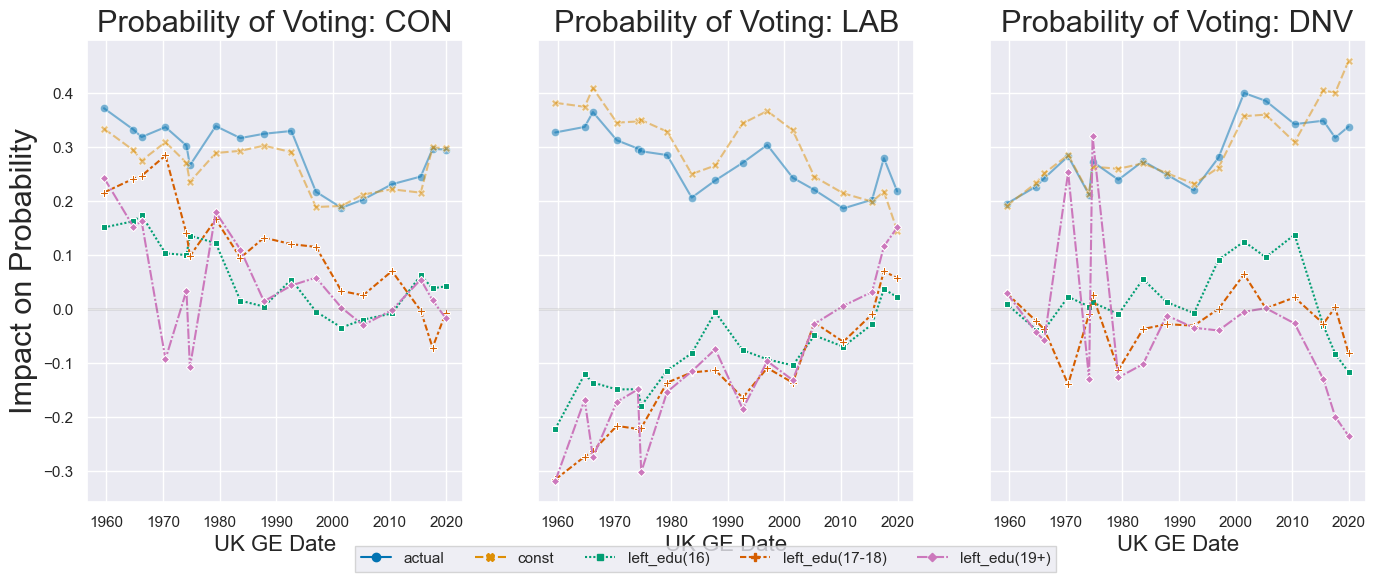

In [24]:
plot_OLS_set(["CON","LAB","DNV"], ["age_left_education_3"], figsize=(16.5, 6),  sharey=True, drop_first=True)

['residence_type_semi-detached house',
 'residence_type_detached house',
 'residence_type_terraced house',
 'residence_type_purpose-built flat',
 'residence_type_semi-detached excl end-terrace',
 'residence_type_flat',
 'residence_type_converted flat',
 'residence_type_bungalow',
 'residence_type_end-terrace house',
 'residence_type_flat,maisonette,bsit',
 'residence_type_other',
 'residence_type_bedsit',
 'residence_type_institution',
 'residence_type_DK',
 'residence_type_caravan',
 'residence_type_tenement']

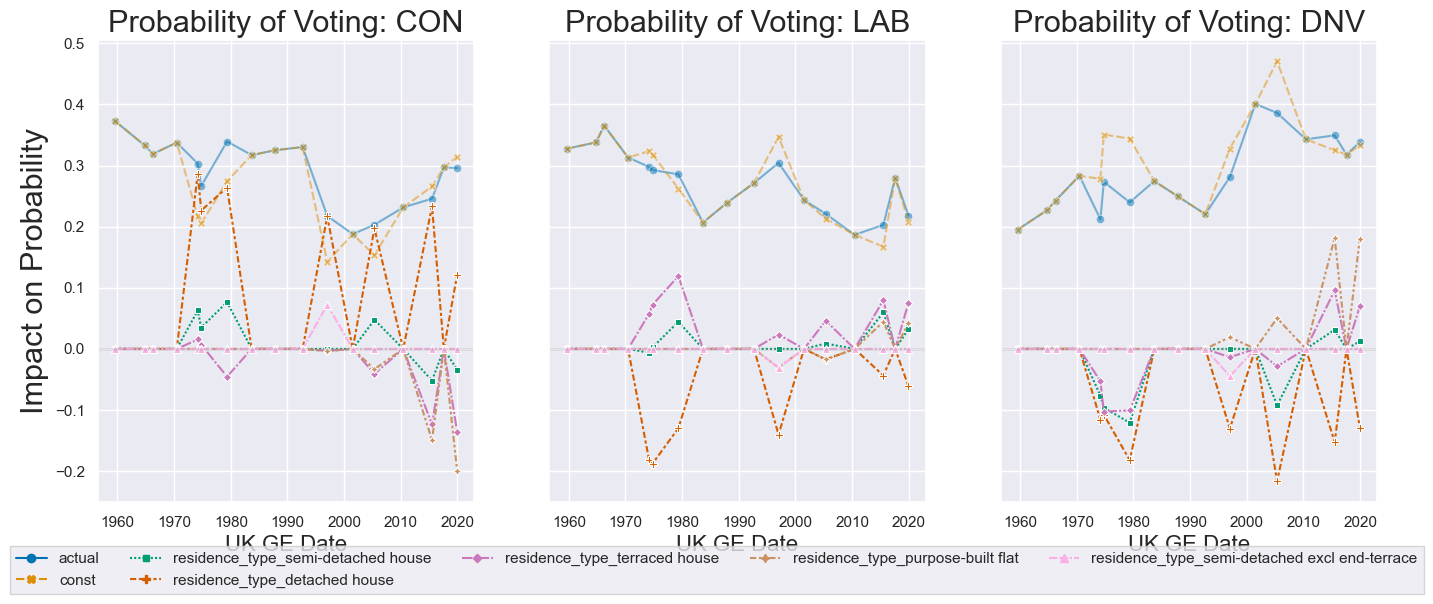

In [32]:
plot_OLS_set(["CON","LAB","DNV"], ["residence_type"], figsize=(16.5, 6),  sharey=True, drop_first=True,
            
             dummied_cols=["residence_type_"+x for x in f2f_harmonised["residence_type"].value_counts().index[0:5]]     
            
            )

In [ ]:
## detached, terraced

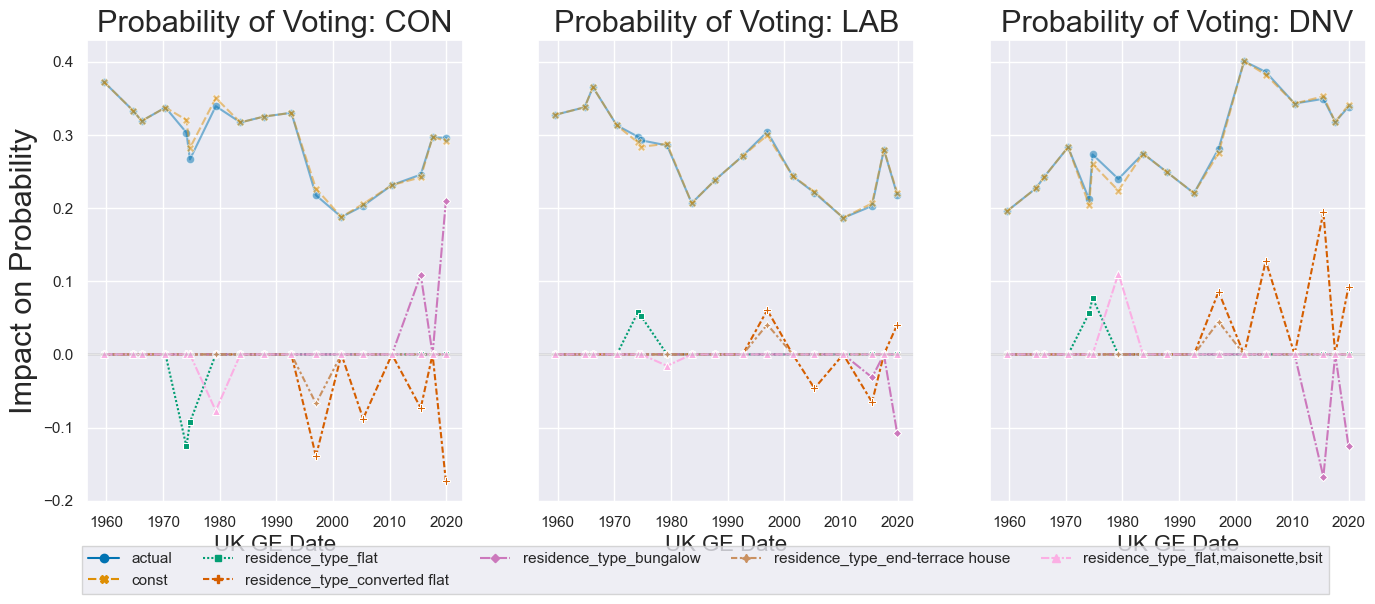

In [33]:
plot_OLS_set(["CON","LAB","DNV"], ["residence_type"], figsize=(16.5, 6),  sharey=True, drop_first=True,
            
             dummied_cols=["residence_type_"+x for x in f2f_harmonised["residence_type"].value_counts().index[5:10]]     
            
            )

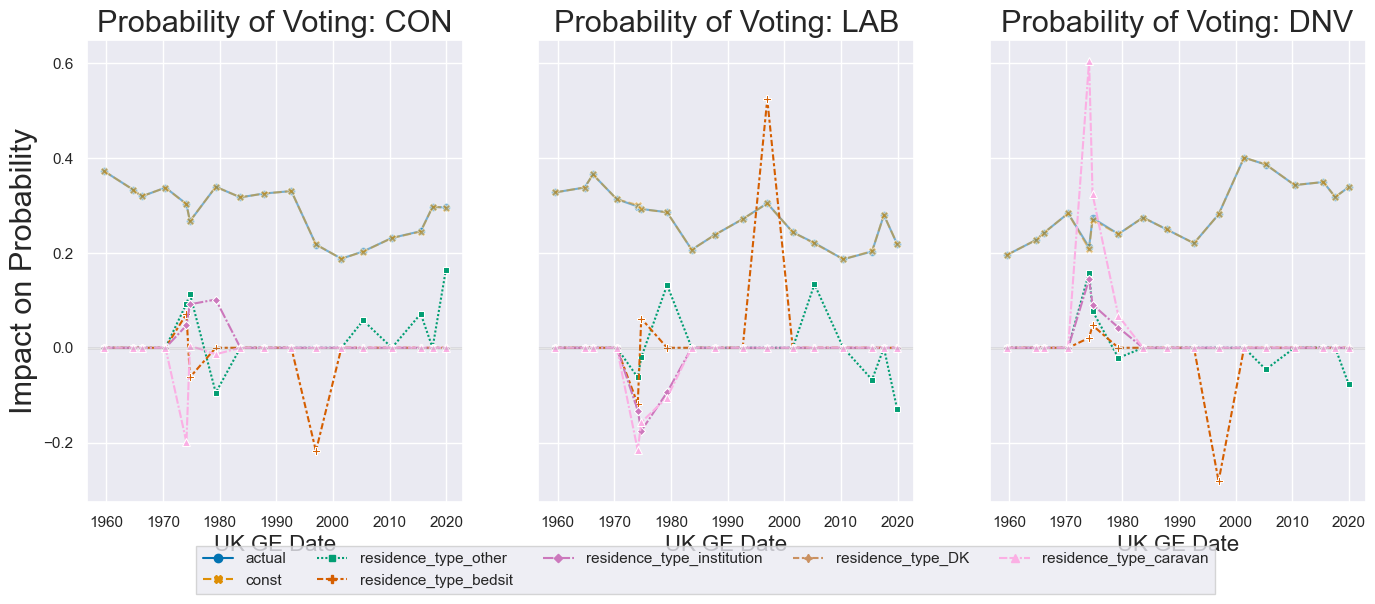

In [34]:
plot_OLS_set(["CON","LAB","DNV"], ["residence_type"], figsize=(16.5, 6),  sharey=True, drop_first=True,
            
             dummied_cols=["residence_type_"+x for x in f2f_harmonised["residence_type"].value_counts().index[10:15]]     
            
            )

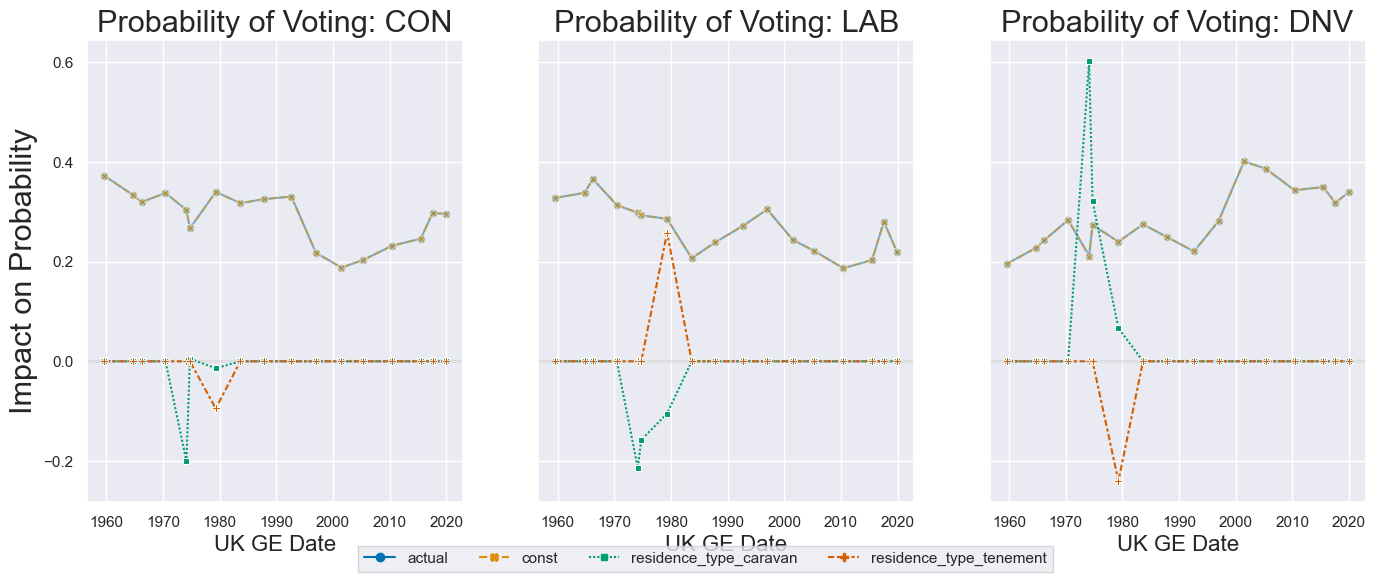

In [52]:
plot_OLS_set(["CON","LAB","DNV"], ["residence_type"], figsize=(16.5, 6),  sharey=True, drop_first=True,
            
             dummied_cols=["residence_type_"+x for x in f2f_harmonised["residence_type"].value_counts().index[15:]]     
            
            )

In [ ]:
# caravan -> DNV, flat/maisonette/bsit -> DNV, purpose_built_flat-> DNV, converted_flat-> DNV, caravan -> DNV
# bedsit -> LL/DNV, terraced -> LL/DNV, tenement -> LL
# bungalow -> AR, detached -> AR,
# other

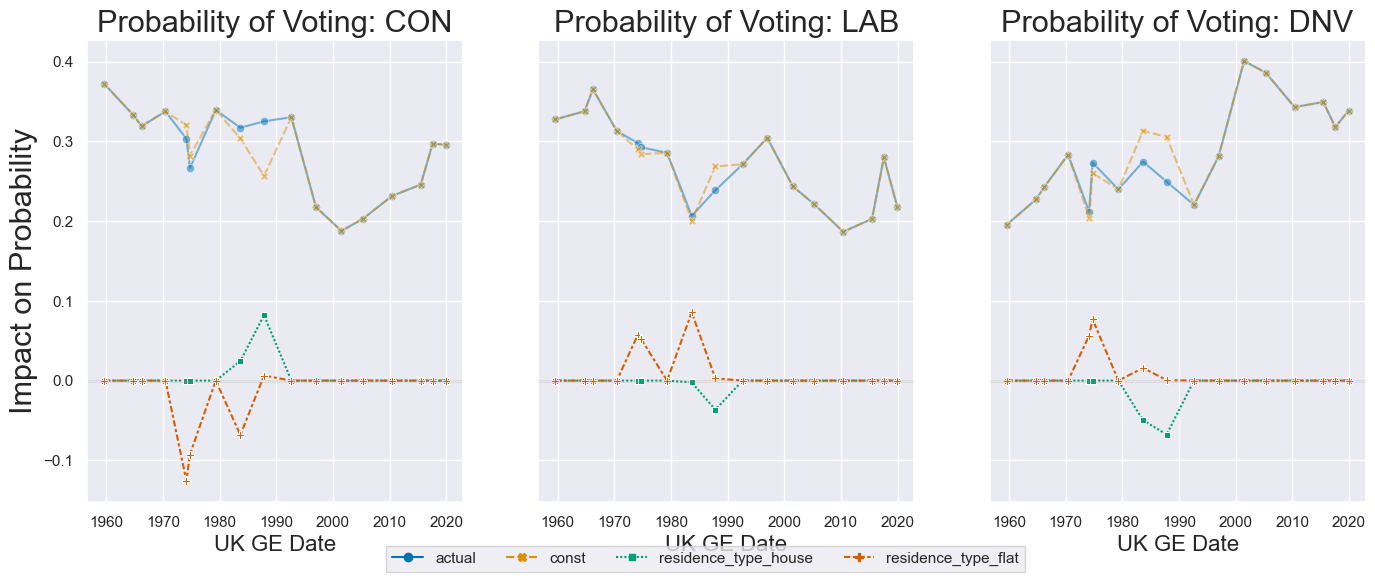

In [45]:
plot_OLS_set(["CON","LAB","DNV"], ["residence_type"], figsize=(16.5, 6),  sharey=True, drop_first=True,
            
             dummied_cols=["residence_type_house","residence_type_flat",]     
            
            )

In [ ]:
## look how it divides by tenure type

In [46]:
f2f_harmonised.groupby("housing")["residence_type"].value_counts()

housing  residence_type                
OWN      house                             5041
         semi-detached house               3921
         detached house                    3741
         terraced house                    2385
         semi-detached excl end-terrace     840
         purpose-built flat                 549
         flat                               366
         bungalow                           219
         end-terrace house                  178
         converted flat                     106
         other                               74
         flat,maisonette,bsit                30
         DK                                  22
         caravan                             13
         bedsit                               9
         institution                          6
         tenement                             2
RENT     semi-detached house               1886
         terraced house                    1669
         house                             1391


In [51]:
f2f_harmonised.groupby("residence_type")["housing"].value_counts(normalize=True).round(2)

residence_type                  housing
DK                              OWN        0.51
                                RENT       0.49
bedsit                          RENT       0.91
                                OWN        0.09
bungalow                        OWN        0.72
                                RENT       0.28
caravan                         OWN        0.87
                                RENT       0.13
converted flat                  RENT       0.65
                                OWN        0.35
detached house                  OWN        0.92
                                RENT       0.08
end-terrace house               OWN        0.59
                                RENT       0.41
flat                            RENT       0.73
                                OWN        0.27
flat,maisonette,bsit            RENT       0.88
                                OWN        0.12
house                           OWN        0.78
                                RENT       0.22


In [ ]:
# tenement&terraced house
# detached&bungalow

In [53]:
f2f_harmonised.groupby('dataset')["housing"].apply(lambda x: x.isnull().sum())

dataset
1959         97
1964        103
1966        103
1970        109
1974_feb     56
1974_oct     16
1979         44
1983        113
1987         76
1992         80
1997         77
2001         49
2005        101
2010         39
2015          0
2017          0
2019         81
Name: housing, dtype: int64

In [57]:
f2f_harmonised["residence_type"][f2f_harmonised["housing"].isnull()].value_counts()

# actually not bad for filling in some gaps!

other                             117
detached house                     96
institution                        71
semi-detached house                67
terraced house                     53
purpose-built flat                 39
semi-detached excl end-terrace     25
converted flat                     15
flat,maisonette,bsit                6
flat                                5
bungalow                            3
bedsit                              2
end-terrace house                   1
caravan                             1
house                               0
tenement                            0
DK                                  0
Name: residence_type, dtype: int64

In [60]:
f2f_harmonised["residence_type"].value_counts()

house                             6432
semi-detached house               5874
detached house                    4181
terraced house                    4107
purpose-built flat                1797
flat                              1373
semi-detached excl end-terrace    1157
converted flat                     315
bungalow                           306
end-terrace house                  303
flat,maisonette,bsit               257
other                              253
bedsit                             107
institution                        105
DK                                  43
caravan                             16
tenement                             4
Name: residence_type, dtype: int64

In [65]:
replace_dict = {'house':'house',
                'semi-detached house':'house',
                'detached house':'house',
                'terraced house':'house',
                'purpose-built flat':'flat',
                'flat':'flat',
                'semi-detached excl end-terrace':'house',
                'converted flat':'flat',
                'bungalow':'house',
                'end-terrace house':'house',
                'flat,maisonette,bsit':'flat',
                'other':np.nan,
                'bedsit':'flat',
                'institution':np.nan,
                'DK':np.nan,
                'caravan':np.nan,
                'tenement':'house',
               }

f2f_harmonised["resid_housevflat"] = f2f_harmonised["residence_type"].replace(replace_dict)
f2f_harmonised["resid_housevflat"].value_counts(dropna=False)

NaN      26518
house    22364
flat      3849
Name: resid_housevflat, dtype: int64

In [64]:
replace_dict = {'house':np.nan,
                'semi-detached house':np.nan,
                'detached house':'detached&bungalow',
                'terraced house':'terrace&tenement',
                'purpose-built flat':np.nan,
                'flat':np.nan,
                'semi-detached excl end-terrace':'terrace&tenement',
                'converted flat':np.nan,
                'bungalow':'detached&bungalow',
                'end-terrace house':'terrace&tenement',
                'flat,maisonette,bsit':np.nan,
                'other':np.nan,
                'bedsit':np.nan,
                'institution':np.nan,
                'DK':np.nan,
                'caravan':np.nan,
                'tenement':'terrace&tenement',
               }

f2f_harmonised["resid_terracevdetached"] = f2f_harmonised["residence_type"].replace(replace_dict)
f2f_harmonised["resid_terracevdetached"].value_counts(dropna=False)

NaN                  42673
terrace&tenement      5571
detached&bungalow     4487
Name: resid_terracevdetached, dtype: int64

In [67]:
f2f_harmonised.columns

Index(['dataset', 'uid', 'housing_det', 'housing', 'inc', 'vote', 'year', 'wt',
       'age', 'vote_simple',
       ...
       'toughlaw', 'death', 'ec_left_right', 'soc_lib_auth',
       'soc_lib_auth_complete', 'ec_left_right_complete', 'wt_norm',
       'residence_type', 'resid_housevflat', 'resid_terracevdetached'],
      dtype='object', length=108)

In [69]:
f2f_harmonised[['residence_type', 'resid_housevflat', 'resid_terracevdetached']].to_pickle("E:\\BES_analysis_data\\Face_to_face\\residence_type.zip", compression='zip')